In [2]:
# first import all of the packages required in this entire project:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from glob import glob
import copy
import joblib
from tqdm import tqdm
tqdm.pandas()
import gc
from collections import defaultdict
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
import cv2
import matplotlib
matplotlib.style.use('ggplot')
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.float_format', '{:.2f}'.format)
import segmentation_models_pytorch as smp
from torchvision.models.resnet import Bottleneck, ResNet
from torchvision import transforms
from randstainna import RandStainNA


In [3]:
# load train_df for blood_vessel:
train_df = pd.read_excel(r"\\fatherserverdw\Kevin\hubmap\unet++\bv_train_df.xlsx")
# train_df.drop('Unnamed: 0',inplace=True)
train_df

,Unnamed: 0,id,image_path,mask_path,source_wsi
0,0,0a993633aa5e,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,1
1,1,0a43459733e7,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2
2,2,0ab9d193fcf6,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2
3,3,0acd70e887b3,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2
4,4,0ae9282b7594,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,4
...,...,...,...,...,...
1617,1617,00d75ad65de3,\\fatherserverdw\Kevin\hubmap\unet++\images\00...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,1
1618,1618,0a1d277fb473,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,3
1619,1619,0a152cf103e4,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2
1620,1620,0b849dde56be,\\fatherserverdw\Kevin\hubmap\unet++\images\0b...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2


In [3]:
find_mean_std_dataset = False # already found it, so False. Turn to true if you want to find std of mean of another dataset.

if find_mean_std_dataset:
    class HubmapDataset(Dataset):
        def __init__(self,df,transform=None):
            self.df = df
            self.directory = df["image_path"].tolist()
            self.transform = transform

        def __len__(self):
            return int(len(self.directory))

        def __getitem__(self,idx):
            path = self.directory[idx]
            image = cv2.imread(path, cv2.COLOR_BGR2RGB)
            if self.transform is not None:
                image = self.transform(image = image)['image']
            return image

    device      = torch.device('cpu')
    num_workers = 0
    image_size  = 384
    batch_size  = 4

    augmentations = A.Compose([A.Resize(height= image_size ,width = image_size ),
                                       A.Normalize(mean=(0,0,0), std=(1,1,1)),
                                       ToTensorV2()])

    unstain2stain_dataset = HubmapDataset(df = train_df, transform = augmentations)# data loader
    image_loader = DataLoader(unstain2stain_dataset,
                              batch_size  = batch_size,
                              shuffle     = False,
                              num_workers = num_workers,
                              pin_memory  = True)

    images = next(iter(image_loader))
    print("Images have a tensor size of {}.".
          format(images.size()))

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader,colour='red'):
        psum    += inputs.sum(axis = [0, 2, 3]) # sum over axis 1
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3]) # sum over axis 1

    # pixel count
    count = len(train_df) * image_size * image_size

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: ' + str(total_mean))
    print('std:  ' + str(total_std))
# results:
# mean: tensor([0.6801, 0.4165, 0.6313])
# std:  tensor([0.1308, 0.2094, 0.1504])


In [4]:
# model configs, note that key is for the different type of resnet50's available for use from lunit
class model_config:
    seed = 42
    key = "MoCoV2"
    train_batch_size = 8
    valid_batch_size = 8
    epochs = 5
    CV_fold = 5
    learning_rate = 0.001
    scheduler = "CosineAnnealingLR"
    T_max = int(30000 / train_batch_size * epochs)  # for cosineannealingLR, explore different values
    weight_decay = 1e-6  # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1, 32 // train_batch_size)  # for scaling accumulated gradients
    eta_min = 1e-5
    dice_alpha = 0.5
    bce_alpha = 0.5
    model_save_directory = os.path.join(os.getcwd(), "model",
                                        str(key))  #assuming os.getcwd is the current training script directory

In [5]:
# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed=42):
    np.random.seed(seed)  #numpy specific random
    random.seed(seed)  # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  # torch specific random
    torch.cuda.manual_seed(seed)  # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary
set_seed(model_config.seed)

In [6]:
# stratify with StratifiedKFold:
new_df_train = train_df.copy(deep=True)
strat_kfold = StratifiedKFold(shuffle = True, random_state = 42,n_splits = model_config.CV_fold) # random_state for reproducibility
for each_fold, (idx1,idx2) in enumerate(strat_kfold.split(X = new_df_train, y = new_df_train["source_wsi"])):
    new_df_train.loc[idx2,'fold'] = int(each_fold) #create new fold column with the fold number (up to 5)
new_df_train["fold"] = new_df_train["fold"].apply(lambda x: int(x)) # somehow doesn't turn to int, so change to int, fold from 0~4
new_df_train

,Unnamed: 0,id,image_path,mask_path,source_wsi,fold
0,0,0a993633aa5e,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,1,4
1,1,0a43459733e7,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2,3
2,2,0ab9d193fcf6,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2,0
3,3,0acd70e887b3,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2,1
4,4,0ae9282b7594,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,4,1
...,...,...,...,...,...,...
1617,1617,00d75ad65de3,\\fatherserverdw\Kevin\hubmap\unet++\images\00...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,1,4
1618,1618,0a1d277fb473,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,3,1
1619,1619,0a152cf103e4,\\fatherserverdw\Kevin\hubmap\unet++\images\0a...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2,4
1620,1620,0b849dde56be,\\fatherserverdw\Kevin\hubmap\unet++\images\0b...,\\fatherserverdw\Kevin\hubmap\unet++\masks\blo...,2,1


In [7]:
save_df = False #only once
if save_df:
    new_df_train.to_excel(r"\\fatherserverdw\Kevin\hubmap\unet++\bv_train_df_CV.xlsx")
grouped = new_df_train.groupby(['fold','source_wsi'])
grouped.fold.count()
# we can see similar distribution

fold  source_wsi
0     1             100
      2              89
      3              82
      4              54
1     1              99
      2              89
      3              82
      4              55
2     1              99
      2              89
      3              82
      4              54
3     1              99
      2              89
      3              82
      4              54
4     1              99
      2              89
      3              82
      4              54
Name: fold, dtype: int64

In [8]:
### try doing randstain na and not doing it:
# train_transforms = transforms.Compose([
#     transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1), # p changed from previous randstainna methods
#     transforms.RandomGrayscale(p=0.2), # p changed from previous randstainna methods
#     RandStainNA( # p changed from previous randstainna methods
#         yaml_file="randstainna.yaml",
#         std_hyper=-0.3,
#         probability=0.8,
#         distribution="normal",
#         is_train=True,
#     )
# ])
# val_transforms = transforms.Compose([RandStainNA( # p changed from previous randstainna methods
#         yaml_file="randstainna.yaml",
#         std_hyper=-0.3,
#         probability=0.8,
#         distribution="normal",
#         is_train=True,
#     )])
train_transforms = A.Compose([
    # A.ColorJitter(brightness = 0.01, contrast = 0.01, saturation = 0.01, hue = 0.01, p = 0.8),
    A.ToGray(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
    ToTensorV2(),
])
val_transforms = A.Compose([A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
    ToTensorV2(),])

In [9]:
import torchvision.transforms.functional as F

In [34]:
class TrainDataSet(Dataset):
    # initialize df, label, imagepath and transforms
    def __init__(self, df, transforms = None, label=True):
        self.df = df
        self.label = label
        self.imagepaths = df["image_path"].tolist()
        self.maskpaths = df["mask_path"].tolist()
        self.transforms = transforms
    # define length, which is simply length of all imagepaths
    def __len__(self):
        return len(self.df)
    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self,idx):
        image_path = self.imagepaths[idx]
        image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.label:
            mask_path = self.maskpaths[idx]
            mask = cv2.imread(mask_path,0)
            mask = np.array(mask)
        if self.transforms is not None: #augmentations for train, augmentation for valid should also be added (
            transformed = self.transforms(image=image,mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(0)
        return image, mask # return tensors of image arrays, image should be 3x 512 x 512, mask 1 x 512 x 512 (need dummy dimension to match dimension)

In [35]:
# define dataloading function:
def load_dataset(fold):
    model_df_train = new_df_train.query("fold!=@fold").reset_index(drop=True)
    model_df_val = new_df_train.query("fold==@fold").reset_index(drop=True)
    train_dataset = TrainDataSet(df=model_df_train, transforms=train_transforms)  # image,mask pair
    val_dataset = TrainDataSet(df=model_df_val, transforms=val_transforms)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=model_config.train_batch_size,
                                  # pin_memory= true allows faster data transport from cpu to gpu
                                  num_workers=0, pin_memory=True, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=model_config.valid_batch_size,
                                num_workers=0, pin_memory=True, shuffle=True)
    return train_dataloader, val_dataloader

In [36]:
train_dataloader, val_dataloader = load_dataset(fold=0)
images, labels = next(iter(train_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))
images, labels = next(iter(val_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))

Images have a tensor size of torch.Size([8, 3, 512, 512]), and Labels have a tensor size of torch.Size([8, 1, 512, 512])
Images have a tensor size of torch.Size([8, 3, 512, 512]), and Labels have a tensor size of torch.Size([8, 1, 512, 512])


In [37]:
def visualize_images(dataset, num_images=5):
    random.seed(42)
    indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 12))
    fig.tight_layout()

    for i, ax_row in enumerate(axes):
        index = indices[i]
        image, mask = dataset[index]

        if dataset.transforms is None:
            ax_row[0].imshow(image)
        else:
            ax_row[0].imshow(image.permute(1, 2, 0))

        ax_row[0].set_title("Image")
        ax_row[0].axis("off")

        ax_row[1].imshow(mask, cmap="gray")
        ax_row[1].set_title("Mask")
        ax_row[1].axis("off")

    plt.show()

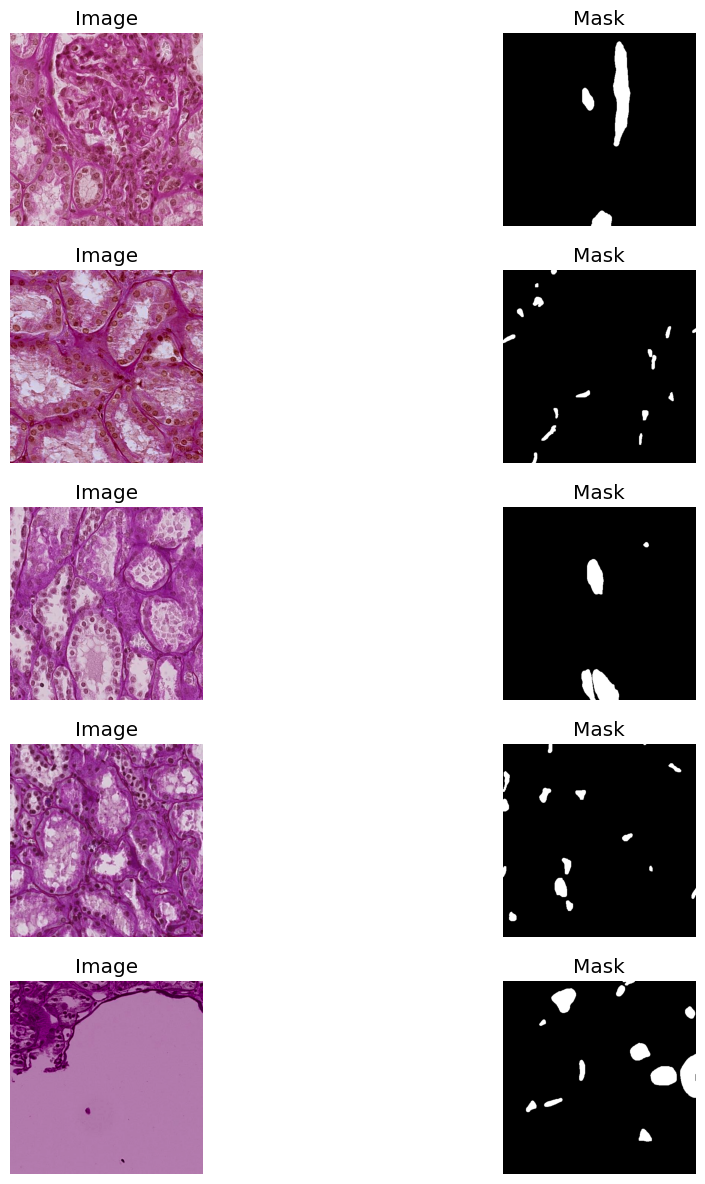

In [38]:
original_dataset = TrainDataSet(df=new_df_train,transforms=None)
visualize_images(original_dataset, num_images=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (1, 512, 512) for image data

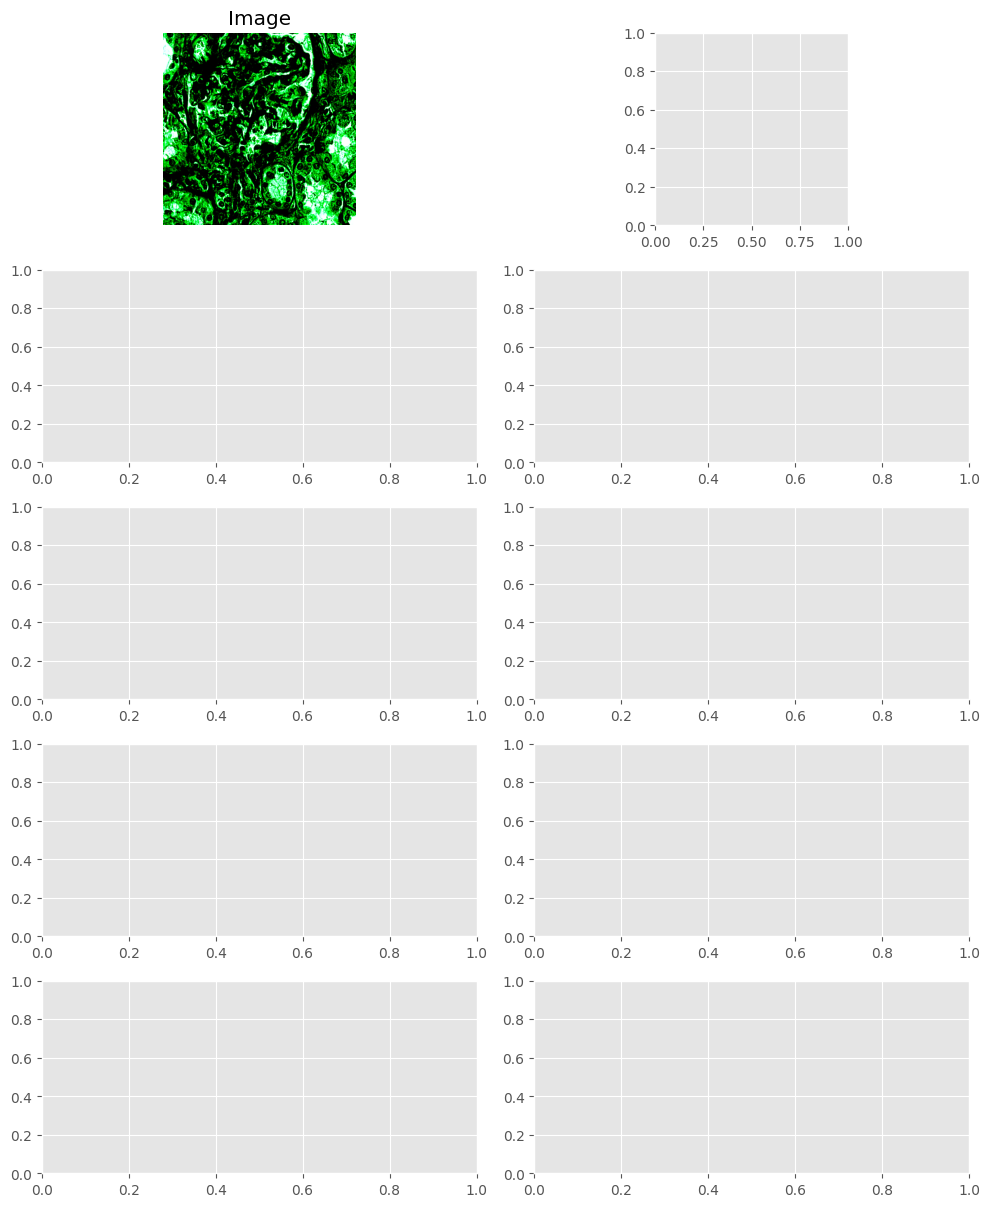

In [39]:
train_dataset = TrainDataSet(df=new_df_train, transforms=train_transforms)
visualize_images(train_dataset, num_images=5)

In [ ]:
# import pretrained resnet50 model:
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url


def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model
#
#
# if __name__ == "__main__":
    # initialize resnet50 trunk using BT pre-trained weight
model_backbone = resnet50(pretrained=True, progress=False, key=model_config.key)

In [ ]:
pretrained_url = get_pretrained_url(model_config.key)
pretrained_url

In [ ]:
# model_backbone = torch.nn.Sequential(*list(model_backbone.children())[:-1]) #removes the 1x1 avgpool layer, removing may keep more sptial information, but also more information,, so longer training time. Including avgpool layer also lead more to a compact representation, which also may be good, depends.
# model_backbone

In [ ]:
def build_model():
    model = smp.UnetPlusPlus(encoder_name="resnet50", encoder_weights=model_config.key, activation=None,
                             in_channels=3, classes=1, decoder_use_batchnorm=True)
    model.to(model_config.device)  # model to gpu
    return model

In [ ]:
dice_loss_func = smp.losses.DiceLoss(mode='multilabel')
bce_loss_func = smp.losses.SoftBCEWithLogitsLoss()

In [ ]:
def loss_func(y_pred,y_true): #weighted avg of the two, maybe explore different weighting if possible?
    return  model_config.dice_alpha * dice_loss_func(y_pred,y_true) + model_config.bce_alpha * bce_loss_func(y_pred,y_true)

In [ ]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32) # binary tensor
    intersection = (y_true*y_pred).sum(dim=dim) # calculate overlapping pixels b/w pred and true for height and width
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim) # denominator, A+B along height and width
    dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0)) # avg over batch & channel to return scalar
    return dice

In [ ]:
def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train() # set mode to train
    dataset_size = 0 #initialize
    running_loss = 0.0 #initialize
    scaler = GradScaler() # enable GradScaler
    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc='Train', colour = 'red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float) # move tensor to gpu
        masks  = masks.to(device, dtype=torch.float) # move tensor to gpu
        batch_size = model_config.train_batch_size # return batch size N.

        with autocast(enabled=True,dtype=torch.float16): # enable autocast for forward pass
            y_pred = model(images) # forward pass, get y_pred from input
            loss   = loss_func(y_pred, masks) # compute losses from y_pred
            loss   = loss / model_config.iters_to_accumulate # need to normalize since accumulating gradients
        scaler.scale(loss).backward() # accumulates the scaled gradients

        if (idx + 1) % model_config.iters_to_accumulate == 0: # scale updates should only happen at batch granularity
            scaler.step(optimizer)
            scaler.update() # update scale for next iteration
            optimizer.zero_grad() # zero the accumulated scaled gradients
            scheduler.step() # change lr,make sure to call this after scaler.step

        running_loss += (loss.item() * batch_size) # update current running loss for all images in batch
        dataset_size += batch_size # update current datasize

        epoch_loss = running_loss / dataset_size # get current epoch average loss
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}')

    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss #return loss for this epoch

In [ ]:
@torch.no_grad() # disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval() # set mode to eval
    dataset_size = 0 #initialize
    running_loss = 0.0 #initialize
    valid_score_history = [] #keep validation score
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation',colour = 'red')
    for idx, (images, masks) in pbar:
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        y_pred  = model(images)
        loss    = loss_func(y_pred, masks)

        running_loss += (loss.item() * model_config.valid_batch_size) #update current running loss
        dataset_size += model_config.valid_batch_size #update current datasize
        epoch_loss = running_loss / dataset_size #divide epoch loss by current datasize

        y_pred = nn.Sigmoid()(y_pred) #sigmoid for multi-class
        valid_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        valid_score_history.append(valid_dice)

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}',
                        lr=f'{current_lr:0.4f}')
    valid_score_history = np.mean(valid_score_history, axis=0)
    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss, valid_score_history #return loss and valid_score_history for this epoch

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):

    start = time.time() # measure time
    best_model_wts = copy.deepcopy(model.state_dict()) #deepcopy
    best_dice      = 0 # initial best score
    best_epoch     = -1 # initial best epoch
    history = defaultdict(list) # history defaultdict to store relevant variables

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler,
                                           dataloader=train_dataloader,
                                           device=model_config.device, epoch=epoch)
        valid_loss, valid_score_history = epoch_valid(model, val_dataloader,
                                                 device=model_config.device,
                                                 epoch=epoch)
        valid_dice = valid_score_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        history['Valid Dice'].append(valid_dice)

        print(f'Valid Dice: {valid_dice:0.4f}')

        # if dice score improves, save the best model
        if valid_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {valid_dice:0.4f})")
            best_dice    = valid_dice
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = os.path.join(model_config.model_save_directory,f"best_epoch-{fold:02d}.pt")
            if not os.path.exists(model_config.model_save_directory):
                os.makedirs(model_config.model_save_directory)
            torch.save(model.state_dict(), PATH) #current directory (on kaggle)
            print("Model Saved!")

        # save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = os.path.join(model_config.model_save_directory,f"latest_epoch-{fold:02d}.pt")
        if not os.path.exists(model_config.model_save_directory):
            os.makedirs(model_config.model_save_directory)
        torch.save(model.state_dict(), PATH)

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    print("Best Dice Score: {:.4f}".format(best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [40]:
model = build_model()
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay=model_config.weight_decay)  # default learning rate
if model_config == "CosineAnnealingLR":  # change to CosineAnnealingLR
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config.T_max,
                                               eta_min=model_config.eta_min)
# Run Training!
for fold in range(model_config.CV_fold):
    print(f'Fold: {fold}')
    train_dataloader, valid_dataloader = load_dataset(fold=fold)
    model = build_model()
    optimizer = optim.Adam(model.parameters(),
                           lr=model_config.learning_rate,
                           weight_decay=model_config.weight_decay)  # default learning rate

    if model_config.scheduler == "CosineAnnealingLR":  # change to CosineAnnealingLR
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max=model_config.T_max,
                                                   eta_min=model_config.eta_min)

    model, history = run_training(model, optimizer, scheduler,
                                  device=model_config.device,
                                  num_epochs=model_config.epochs)

Fold: 0
Epoch 1/5

Train:   2%|▏         | 3/163 [00:05<04:21,  1.64s/it, lr=0.00100, train_loss=-1.0497]C:\Users\Kevin\.conda\envs\hubmap\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Train:   6%|▌         | 9/163 [00:12<03:28,  1.35s/it, lr=0.00100, train_loss=-1.1782]

KeyboardInterrupt

